# Data preprocessing

data preprocessing includes: artifact detection, handling bad channels, rejecting bad data spans and breaks... for detail: [https://mne.tools/stable/auto_tutorials/preprocessing/index.html](https://mne.tools/stable/auto_tutorials/preprocessing/index.html)

we will use MNE python lin to process them.(also you can use EEGLAB on matlab toolbox to do it: [https://www.youtube.com/watch?v=uFpAnHP0J2E](https://www.youtube.com/watch?v=uFpAnHP0J2E))

**Because this dataset is very regular, fewer preprocessing steps are required.**

we also load the BCI Competition IV 2a dataset and processing it.

In [1]:
import mne
import matplotlib.pyplot as plt
import pandas

# picture presented by qt5 or inline
%matplotlib inline

# load dataset
dataset_path = "../../datasets/BCI_competition_IV_dataset/"
raw_data = mne.io.read_raw_gdf(dataset_path + "BCICIV_2a_gdf/A01T.gdf", eog= ['EOG-left','EOG-central','EOG-right'], preload=True)

# drop the eog channels we do not use
raw_data.drop_channels(['EOG-left','EOG-central','EOG-right'])

# rename the channels
mne.rename_channels(raw_data.info, {
    'EEG-Fz': 'Fz', 'EEG-0': 'FC3', 'EEG-1': 'FC1', 'EEG-2':'FCz', 'EEG-3':'FC2',
    'EEG-4': 'FC4', 'EEG-5': 'C5','EEG-C3': 'C3', 'EEG-6': 'C1', 'EEG-Cz': 'Cz',
    'EEG-7': 'C2', 'EEG-C4': 'C4', 'EEG-8': 'C6', 'EEG-9': 'CP3', 'EEG-10':'CP1',
    'EEG-11': 'CPz', 'EEG-12': 'CP2', 'EEG-13': 'CP4', 'EEG-14': 'P1', 'EEG-Pz': 'Pz',
    'EEG-15':'P2', 'EEG-16':'POz'})

# set montage of the channels
raw_data.set_montage(mne.channels.make_standard_montage('standard_1020'))

print("raw data information", raw_data.info)
# raw_data.plot()

Extracting EDF parameters from D:\Projects\datasets\BCI_competition_IV_dataset\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


D:\anaconda3\envs\mne_py3.8\lib\contextlib.py:120: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


raw data information <Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
>


## filtering and resampling data


In [2]:
# filter raw data (8Hz,30Hz)
filtered_raw_data = raw_data.copy().filter(l_freq=7, h_freq=35)
# raw_data.plot(title='no filter raw data')
# filtered_raw_data.plot(title='filtered data')
raw_data = filtered_raw_data
del filtered_raw_data

# resample the data to 100Hz
raw_data.resample(sfreq=200)
print(raw_data.info)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)

<Info | 8 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCz, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 highpass: 7.0 Hz
 lowpass: 35.0 Hz
 meas_date: 2005-01-17 12:00:00 UTC
 nchan: 22
 projs: []
 sfreq: 200.0 Hz
>


## artifact detection and removal

Artifacts are parts of the recorded signal that arise from sources other than the source of interest (i.e., neuronal activity in the brain). As such, artifacts are a form of interference or noise relative to the signal of interest.

[**ICA algorithm**](https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py)

## handling bad channels

Sometimes individual channels malfunction and provide data that is too noisy to be usable.

## rejecting bad data spans and breaks

the origin data has rejected trail annotation, we can use mne to detect it

more mne process data tutorial: [https://mne.tools/stable/auto_tutorials/index.html](https://mne.tools/stable/auto_tutorials/index.html)

In [3]:
# rename annotation description to reject when segmenting epochs (origin dataset description '1023')
raw_data.annotations.rename({'1023': 'bad_1023'})

<Annotations | 603 segments: 1072 (1), 276 (1), 277 (1), 32766 (9), 768 ...>

## segmenting continuous data into epochs

Epochs objects are a data structure for representing and analyzing equal-duration chunks of the EEG/MEG signal.(A trial)

we can visualize the average epochs data and evoked data(ERP event related potential)

Used Annotations descriptions: ['1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 original time points ...
15 bad epochs dropped
epochs information:  <Epochs |  273 events (all good), -0.2 - 0.8 sec, baseline -0.2 – 0 sec, ~9.2 MB, data loaded,
 'left': 69
 'right': 69
 'foot': 68
 'tongue': 67>
epochs dropped for:  {('IGNORED',), ('bad_1023',), ()}
Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


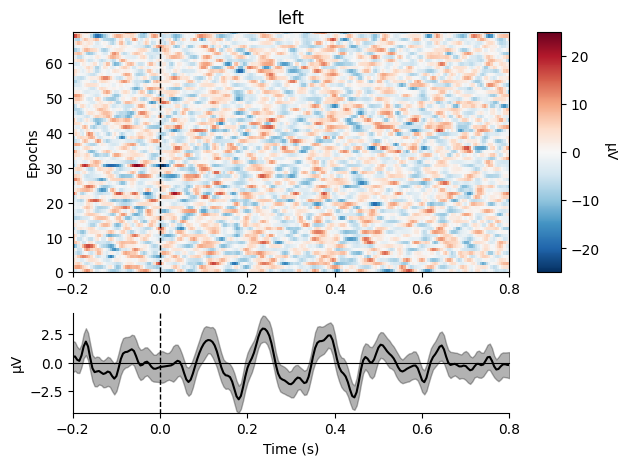

Not setting metadata
69 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


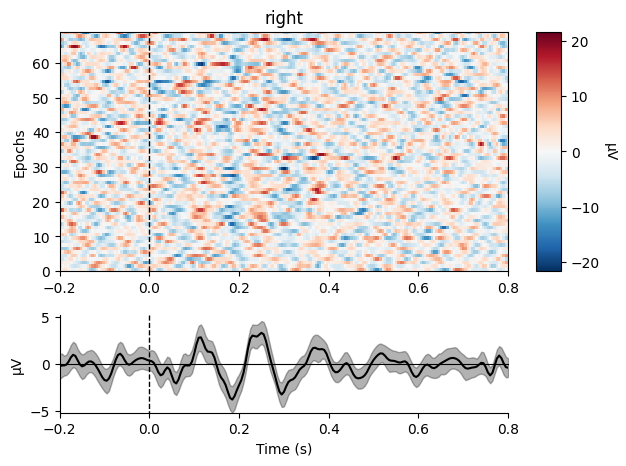

Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


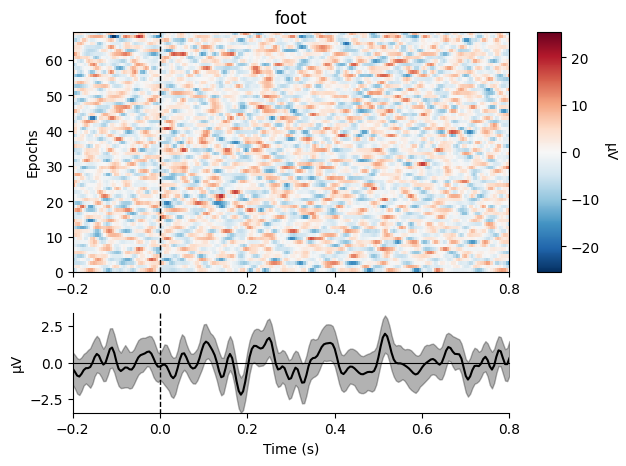

Not setting metadata
67 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


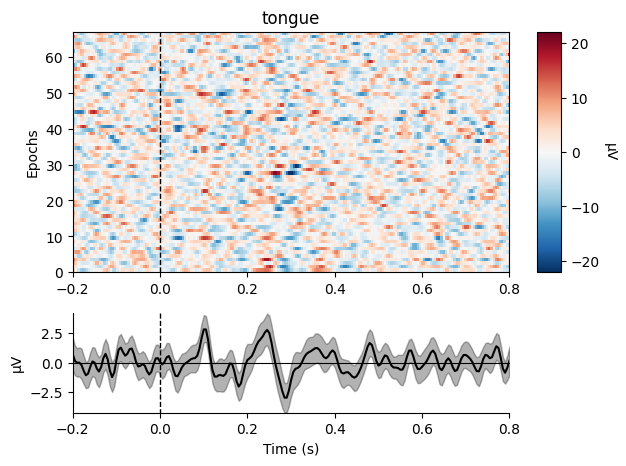

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


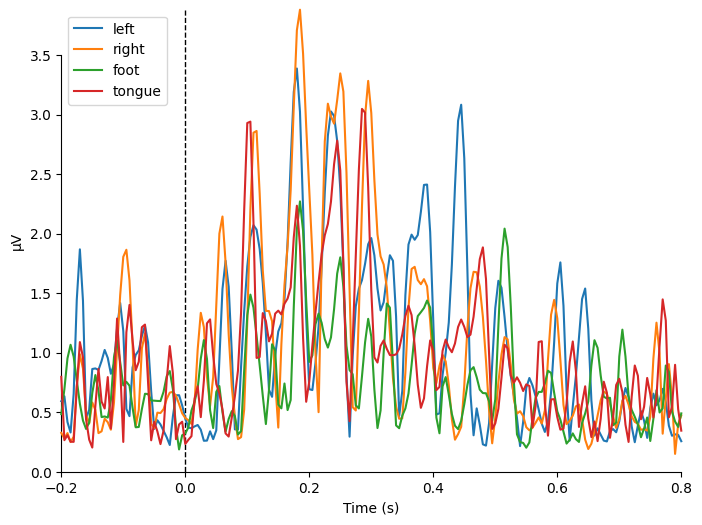

[<Figure size 800x600 with 1 Axes>]

In [4]:
# get events from annotations
events_mapping = {'276':276, '277':277, '768':768, '769':769, '770':770, '771':771, '772':772, '783':783, 'bad_1023':1023, '1072': 1072, '32766':32766}
events, _ = mne.events_from_annotations(raw_data, event_id=events_mapping)

# segment into epochs by events(-0.2s 0.8s)
epochs = mne.Epochs(raw_data, events, tmin=-0.2, tmax=0.8, event_repeated='merge',preload=True, event_id={'left':769, 'right': 770, 'foot': 771, 'tongue':772})
print("epochs information: ", epochs)
print("epochs dropped for: ", set(epochs.drop_log))

# visualize the average epochs fig for 4 classes
epochs['left'].plot_image(title='left', combine='mean')
epochs['right'].plot_image(title='right', combine='mean')
epochs['foot'].plot_image(title='foot', combine='mean')
epochs['tongue'].plot_image(title='tongue', combine='mean')

# plot the evoked fig
evoked_dict = {'left': epochs['left'].average(), 'right': epochs['right'].average(), 'foot': epochs['foot'].average(), 'tongue': epochs['tongue'].average()}
mne.viz.plot_compare_evokeds(evoked_dict)

## save data for ml or dl model

The epochs data can save as df or np data, so we can do the later work on it. This notebook can let us know more about eeg data analysis and the usage of mne-python lib.There are more and more tools for eeg(emg...) analysis or deap learning lib such as [mobba](http://moabb.neurotechx.com/docs/index.html), [Braindecode](https://braindecode.org/)... based or reference mne-python lib, which provide more convenient approach to work.(more details for my code)

In [5]:
# convert to Dataframe class
epochs_df = epochs.to_data_frame()
print(epochs_df.iloc[100:110,:6])

      time condition  epoch         Fz       FC3        FC1
100  0.300    tongue      8 -13.086987 -9.004095 -10.991960
101  0.305    tongue      8 -11.126983 -7.368339  -8.456071
102  0.310    tongue      8  -7.248403 -6.041770  -5.577660
103  0.315    tongue      8  -3.820124 -5.873703  -4.011240
104  0.320    tongue      8  -3.015198 -6.899472  -4.702958
105  0.325    tongue      8  -4.628753 -8.257781  -6.739067
106  0.330    tongue      8  -5.937488 -8.680188  -7.656162
107  0.335    tongue      8  -4.027705 -7.205158  -5.339250
108  0.340    tongue      8   1.508393 -3.632486   0.087853
109  0.345    tongue      8   8.147499  1.491696   6.255920
